In [1]:
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
import pandas as pd

In [16]:
from google.colab import drive
drive.mount('/content/drive')
print("connected to my drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
connected to my drive


In [32]:
path2 = '/content/drive/MyDrive/USA_covidlatest_dataset_highlycoreleated.csv'
df = pd.read_csv(path2)

In [4]:
# df['date'] = pd.to_datetime(df['date'], dayfirst=True)
# df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')


In [33]:
df3=df[['people_fully_vaccinated']]

In [22]:

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

In [23]:
#Create training and testing datasets
train_start_dt = '2021-01-01'
test_start_dt = '2022-01-01'

In [24]:

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

In [25]:

# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = RandomForestRegressor(n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict([testX])
	return yhat[0]

In [26]:
# load and plot the time series dataset
from pandas import read_csv
from matplotlib import pyplot
# load dataset
values = df3.values
# plot dataset


In [ ]:
values

In [28]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = random_forest_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.3f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, 1], predictions

>expected=376127683.000, predicted=376027200.7
>expected=376188792.000, predicted=376094554.9
>expected=376283883.000, predicted=376149143.9
>expected=376361456.000, predicted=376236190.1
>expected=376397434.000, predicted=376313653.7
>expected=376418417.000, predicted=376368077.5
>expected=376498576.000, predicted=376399168.1
>expected=376555986.000, predicted=376462183.2
>expected=376613773.000, predicted=376519242.8
>expected=376672513.000, predicted=376581404.8
>expected=377127587.000, predicted=376638506.9
>expected=377160625.000, predicted=376946855.2
MAE: 139211.9


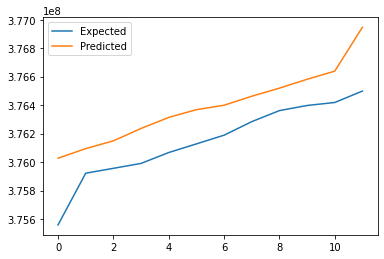

In [29]:
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)
mae, y, yhat = walk_forward_validation(data, 12)
print('MAE: %.1f' % mae)
# plot expected vs predicted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

In [30]:

# finalize model and make a prediction for monthly births with random forest
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.ensemble import RandomForestRegressor
 
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values
 
# load the dataset

values = df3.values
# transform the time series data into supervised learning
train = series_to_supervised(values, n_in=6)
# split into input and output columns
trainX, trainy = train[:, :-1], train[:, -1]
# fit model
model = RandomForestRegressor(n_estimators=1000)
model.fit(trainX, trainy)
# construct an input for a new prediction
row = values[-6:].flatten()
# make a one-step prediction
yhat = model.predict(asarray([row]))
print('Input: %s, Predicted: %.3f' % (row, yhat[0]))

Input: [3.76498576e+08 3.76555986e+08 3.76613773e+08 3.76672513e+08
 3.77127587e+08 3.77160625e+08], Predicted: 377089829.728


In [31]:
import numpy as np
from sklearn import metrics